In [1]:
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import mapping

import pandas as pd
import numpy as np

import dask
from dask.distributed import Client
import dask.dataframe as dd

from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45589,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:38171,Total threads: 2
Dashboard: http://127.0.0.1:33975/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:34411,


# GBIF data preparation

In [3]:
# Open GBIF data as dask dataframe
ddf_gbif = dd.read_csv(
    #"/home/susannaioni/s3/data/gbif/austria/occurrence.txt",
    "/home/susannaioni/s3/data/gbif/R_Ferr/occurrence.txt",
    on_bad_lines='skip',
    sep="\t", 
    usecols=["gbifID", "collectionCode", "basisOfRecord", "countryCode", "eventDate", 
             "year", "month", "day", "decimalLatitude", "decimalLongitude", 
             "hasCoordinate", "coordinateUncertaintyInMeters", "scientificName", 
             "basisOfRecord", "datasetName", "recordedBy"],
    dtype={"gbifID":"int64",
           "collectionCode":"string",
           "basisOfRecord":"string",
           "countryCode":"string",
           "eventDate":"string",
           "year":"string", 
           "month":"string",
           "day":"string",
           "decimalLatitude":"float32",
           "decimalLongitude":"float32",
           "hasCoordinate":"string",
           "coordinateUncertaintyInMeters":"float32",
           "scientificName":"string",
           "basisOfRecord":"str",
           "datasetName":"str",
           "recordedBy":"str"
          },
    blocksize=25e6,
)

In [4]:
# Only data records with Coordinate information and valid latitude/longitude
ddf_gbif = ddf_gbif.loc[ddf_gbif['hasCoordinate'] == "true"]
ddf_gbif = ddf_gbif.dropna(subset=['decimalLatitude', 'decimalLongitude'])

In [5]:
# Filter data based on criterias
filter = ( ddf_gbif["scientificName"].isin(['Rhododendron ferrugineum L.']) ) & \
         ( ddf_gbif["coordinateUncertaintyInMeters"] <= 100 ) & \
         ( ddf_gbif["countryCode"].isin(['AT']) )
ddf_gbif = ddf_gbif[filter] 

In [6]:
# Rename to sane names
ddf_gbif = ddf_gbif.rename(columns={'decimalLatitude':'latitude', 'decimalLongitude':'longitude'})

In [7]:
ddf_gbif.head()

,gbifID,collectionCode,datasetName,basisOfRecord,recordedBy,eventDate,year,month,day,countryCode,latitude,longitude,coordinateUncertaintyInMeters,scientificName,hasCoordinate
262,3330504905,Observations,iNaturalist research-grade observations,HUMAN_OBSERVATION,matejgrunt,2021-07-18T13:00:10,2021,7,18,AT,46.559402,13.249622,48.0,Rhododendron ferrugineum L.,true
266,3860426190,Observations,iNaturalist research-grade observations,HUMAN_OBSERVATION,elinatrattner,2022-06-26T13:49:01,2022,6,26,AT,47.177711,13.353652,41.0,Rhododendron ferrugineum L.,true
269,4039361210,Observations,iNaturalist research-grade observations,HUMAN_OBSERVATION,Tobias Gratzer,2020-06-20T09:16,2020,6,20,AT,46.601677,13.109278,4.0,Rhododendron ferrugineum L.,true
275,4524965485,Observations,iNaturalist research-grade observations,HUMAN_OBSERVATION,Michael Steinwandter,2015-07-04T15:45,2015,7,4,AT,46.995541,11.201587,10.0,Rhododendron ferrugineum L.,true
289,4153927376,Observations,iNaturalist research-grade observations,HUMAN_OBSERVATION,Wolfgang Bacher,2023-07-08T10:17,2023,7,8,AT,47.387543,11.185128,2.0,Rhododendron ferrugineum L.,true


# Merge with other data

In [8]:
xda_lat = xr.DataArray(data=ddf_gbif.latitude,
                       coords={"gbifID":ddf_gbif.gbifID},
                       dims=["gbifID"])

In [9]:
xda_lon = xr.DataArray(data=ddf_gbif.longitude,
                       coords={"gbifID":ddf_gbif.gbifID},
                       dims=["gbifID"])

## Merge DEM data

In [10]:
# Load aspect data
xds_aspect = rioxarray.open_rasterio(
    "/home/susannaioni/s3/data/oe3d/aspect/oe3d_aspect_merge.tif",
    cache=False, chunks=True, lock=False, default_name="aspect")

In [11]:
# Load shade data
xds_shade = rioxarray.open_rasterio(
    "/home/susannaioni/s3/data/oe3d/shade/oe3d_shade_merge.tif",
    cache=False, chunks=True, lock=False, default_name="shade")

In [12]:
# Load slope data
xds_slope = rioxarray.open_rasterio(
    "/home/susannaioni/s3/data/oe3d/slope/oe3d_slope_merge.tif",
    cache=False, chunks=True, lock=False, default_name="slope")

In [13]:
# Load wetness data
xds_wetness = rioxarray.open_rasterio(
    "/home/susannaioni/s3/data/oe3d/wetness/oe3d_wetness_merge.tif",
    cache=False, chunks=True, lock=False, default_name="wetness")

In [14]:
xds_oe3d = xr.merge([xds_aspect,xds_shade,xds_slope,xds_wetness])

In [15]:
xds_oe3d

<xarray.Dataset> Size: 7GB
Dimensions:      (band: 1, x: 32401, y: 14401)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 259kB 9.0 9.0 9.001 9.001 ... 18.0 18.0 18.0 18.0
  * y            (y) float64 115kB 50.0 50.0 50.0 50.0 ... 46.0 46.0 46.0 46.0
    spatial_ref  int64 8B 0
Data variables:
    aspect       (band, y, x) float32 2GB dask.array<chunksize=(1, 1035, 32401), meta=np.ndarray>
    shade        (band, y, x) float32 2GB dask.array<chunksize=(1, 1035, 32401), meta=np.ndarray>
    slope        (band, y, x) float32 2GB dask.array<chunksize=(1, 1035, 32401), meta=np.ndarray>
    wetness      (band, y, x) float32 2GB dask.array<chunksize=(1, 1035, 32401), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
# Use gbif occurance data and extract nearest habitat value with sel
xds_occ_oe3d = xds_oe3d.sel(
    y=xda_lat,
    x=xda_lon,
    method="nearest")

In [17]:
xds_occ_oe3d = xds_occ_oe3d.drop_vars("spatial_ref")

In [18]:
xds_occ_oe3d

<xarray.Dataset> Size: 72kB
Dimensions:  (band: 1, gbifID: 1811)
Coordinates:
  * band     (band) int64 8B 1
    x        (gbifID) float64 14kB 13.25 13.35 13.11 11.2 ... 13.02 13.74 9.834
    y        (gbifID) float64 14kB 46.56 47.18 46.6 47.0 ... 47.02 46.87 47.27
  * gbifID   (gbifID) int64 14kB 3330504905 3860426190 ... 4138255872 4165455510
Data variables:
    aspect   (band, gbifID) float32 7kB dask.array<chunksize=(1, 1811), meta=np.ndarray>
    shade    (band, gbifID) float32 7kB dask.array<chunksize=(1, 1811), meta=np.ndarray>
    slope    (band, gbifID) float32 7kB dask.array<chunksize=(1, 1811), meta=np.ndarray>
    wetness  (band, gbifID) float32 7kB dask.array<chunksize=(1, 1811), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# Create occurrence data frame

In [19]:
# Convert xarray object to dataframe
ddf_occ_oe3d = xds_occ_oe3d.to_dask_dataframe().set_index("gbifID").add_prefix("oe3d_")

In [20]:
# Load the data into memory
df_occ = ddf_occ_oe3d.compute()

In [21]:
# Set Rhododendron ferrugineum Variable
df_occ["RhododendronFerrugineum"] = True

In [22]:
# Drop band
df_occ = df_occ.drop("oe3d_band", axis=1)

In [23]:
df_occ.head()

,oe3d_x,oe3d_y,oe3d_aspect,oe3d_shade,oe3d_slope,oe3d_wetness,RhododendronFerrugineum
gbifID,,,,,,,
1847411512,11.780278,47.031944,3.546484,1.836499,1.570760,-15.751160,True
1891293252,14.214444,47.410833,3.559817,1.827420,1.570768,-16.855408,True
1898786393,14.191389,47.394722,0.083153,1.096447,1.570773,-16.200327,True
1933549454,9.848333,47.293611,6.283185,1.046744,1.570241,-15.684168,True
1978815127,13.871389,46.780556,2.308611,2.355026,1.570759,-16.387257,True


# Pre random sample the non occurrence data

In [24]:
# Select no occurrence data
xds_no_occ = xds_oe3d.drop_sel(
    y=df_occ['oe3d_y'],
    x=df_occ['oe3d_x'])

In [25]:
xds_stack = xds_no_occ.drop_indexes(["x","y"]).drop_vars(['spatial_ref']).stack(sample=("x","y"))

In [83]:
# TODO: Remove this workaround
# Sample more occurrences, because of fill_values in raster dataset
xds_sample = xds_stack.isel(
    sample=sorted(np.random.randint(0, xds_stack.sample.shape, 12*len(df_occ)))
).compute()

# Remove dimension band, drop fill_values and reduce to a multiple amount of occurrence samples
xds_sample = xds_sample.squeeze("band").drop_vars("band")
xds_sample = xds_sample.where(xds_sample.wetness!=0,drop=True)
xds_sample = xds_sample.isel(sample=sorted(np.random.randint(0, xds_sample.sample.shape, 10*len(df_occ))))

In [84]:
xds_sample

<xarray.Dataset> Size: 724kB
Dimensions:  (sample: 18110)
Coordinates:
  * sample   (sample) object 145kB MultiIndex
  * x        (sample) float64 145kB 9.0 9.004 9.005 9.005 ... 18.0 18.0 18.0
  * y        (sample) float64 145kB 46.92 46.01 47.69 46.9 ... 48.68 48.68 47.49
Data variables:
    aspect   (sample) float32 72kB 5.961 2.731 3.142 ... 0.4636 0.4636 0.000581
    shade    (sample) float32 72kB 0.8858 2.289 1.934 ... 1.345 1.345 1.047
    slope    (sample) float32 72kB 1.571 1.571 1.377 1.571 ... 1.571 1.571 1.57
    wetness  (sample) float32 72kB -13.4 -15.94 -8.462 ... -16.05 -16.05 -12.65
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [85]:
# Create dataframe from sampled non occurrence data
df_stack = xds_sample.to_dataframe().add_prefix("oe3d_").reset_index(drop=True)

In [86]:
df_stack['RhododendronFerrugineum'] = False

In [87]:
df_stack.head()

,oe3d_aspect,oe3d_shade,oe3d_slope,oe3d_wetness,oe3d_x,oe3d_y,RhododendronFerrugineum
0,5.961233,0.885834,1.570621,-13.404040,9.000278,46.918889,False
1,2.730602,2.289088,1.570765,-15.936505,9.004167,46.005833,False
2,3.141593,1.933552,1.377494,-8.461668,9.005000,47.692222,False
3,6.080863,0.939387,1.570782,-17.376083,9.005000,46.901111,False
4,6.080863,0.939387,1.570782,-17.376083,9.005000,46.901111,False


# Concatenate pre sampled data

In [88]:
df_sampled = pd.concat([df_occ,df_stack])

In [89]:
df_sampled

,oe3d_x,oe3d_y,oe3d_aspect,oe3d_shade,oe3d_slope,oe3d_wetness,RhododendronFerrugineum
1847411512,11.780278,47.031944,3.546484,1.836499,1.570760,-15.751160,True
1891293252,14.214444,47.410833,3.559817,1.827420,1.570768,-16.855408,True
1898786393,14.191389,47.394722,0.083153,1.096447,1.570773,-16.200327,True
1933549454,9.848333,47.293611,6.283185,1.046744,1.570241,-15.684168,True
1978815127,13.871389,46.780556,2.308611,2.355026,1.570759,-16.387257,True
...,...,...,...,...,...,...,...
18105,17.993889,48.222500,3.926991,1.570518,1.570403,-16.111979,False
18106,17.994167,48.180278,1.570796,1.933122,1.376986,-5.585593,False
18107,17.998889,48.682500,0.463648,1.345253,1.570755,-16.049751,False
18108,17.998889,48.682500,0.463648,1.345253,1.570755,-16.049751,False


# Train xgboost model

In [90]:
# Sample for xgboost model from equally distributed pre sampled data
train, test = train_test_split(df_sampled, test_size=0.2, random_state=3)

In [91]:
# Use "hist" for constructing the trees.
clf = xgb.XGBClassifier(tree_method="hist",scale_pos_weight=0.1)

In [92]:
# Fit the model
clf.fit(train.iloc[:, :-1], train.iloc[:, -1])
#clf.fit(df_sampled.iloc[:, :-1], df_sampled.iloc[:, -1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
# Feature importance
for i in zip(df_sampled.iloc[:,:-1].keys(),clf.feature_importances_):
    print(i) 

('oe3d_x', 0.2406744)
('oe3d_y', 0.4281062)
('oe3d_aspect', 0.071684815)
('oe3d_shade', 0.07268456)
('oe3d_slope', 0.09701607)
('oe3d_wetness', 0.08983389)


## Fit model on coarsened raw data

In [70]:
# Coarsen raw dataset
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    xds_fit = xds_oe3d.coarsen(x=10,y=10,boundary="trim").mean()

In [71]:
xds_fit = xds_fit.drop_indexes(["x","y"]).drop_vars(['spatial_ref']).stack(sample=("x","y"))

In [72]:
xds_fit

<xarray.Dataset> Size: 187MB
Dimensions:  (band: 1, sample: 4665600)
Coordinates:
  * band     (band) int64 8B 1
  * sample   (sample) object 37MB MultiIndex
  * x        (sample) float64 37MB 9.001 9.001 9.001 9.001 ... 18.0 18.0 18.0
  * y        (sample) float64 37MB 50.0 50.0 49.99 49.99 ... 46.01 46.0 46.0
Data variables:
    aspect   (band, sample) float32 19MB dask.array<chunksize=(1, 332640), meta=np.ndarray>
    shade    (band, sample) float32 19MB dask.array<chunksize=(1, 332640), meta=np.ndarray>
    slope    (band, sample) float32 19MB dask.array<chunksize=(1, 332640), meta=np.ndarray>
    wetness  (band, sample) float32 19MB dask.array<chunksize=(1, 332640), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [73]:
# Create dataframe from coarsend data for testing
df_fit = xds_fit.to_dataframe().add_prefix("oe3d_").reset_index(drop=True)

In [74]:
df_fit = df_fit[['oe3d_x', 'oe3d_y', 'oe3d_aspect', 'oe3d_shade', 'oe3d_slope', 'oe3d_wetness']]

In [75]:
# predict with the model
df_fit['predic'] = clf.predict_proba(df_fit)[:,-1]

In [76]:
# Convert to xarray dataset
xr_fit = df_fit[["oe3d_x","oe3d_y","predic"]].drop_duplicates(
    ["oe3d_x","oe3d_y"]).set_index(["oe3d_x","oe3d_y"]).to_xarray()

In [77]:
# Rename dimensions
xr_fit = xr_fit.rename({"oe3d_x":"x","oe3d_y":"y"})

## Clip to austria and plot

In [78]:
# Set coord reference system infos
xr_fit.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
xr_fit.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 19MB
Dimensions:      (x: 3240, y: 1440)
Coordinates:
  * x            (x) float64 26kB 9.001 9.004 9.007 9.01 ... 17.99 18.0 18.0
  * y            (y) float64 12kB 46.0 46.0 46.01 46.01 ... 49.99 50.0 50.0
    spatial_ref  int64 8B 0
Data variables:
    predic       (x, y) float32 19MB 6.49e-06 2.052e-05 ... 0.0001802 0.0001802

In [79]:
# Load nuts regions
nuts = gpd.read_file("/home/susannaioni/s3/data/nuts/NUTS_RG_20M_2021_4326.geojson")

In [80]:
# Clip to Austrian border and drop rest
xr_fit = xr_fit.rio.clip(nuts[nuts.id=="AT"].geometry.apply(mapping), nuts.crs, drop=True)

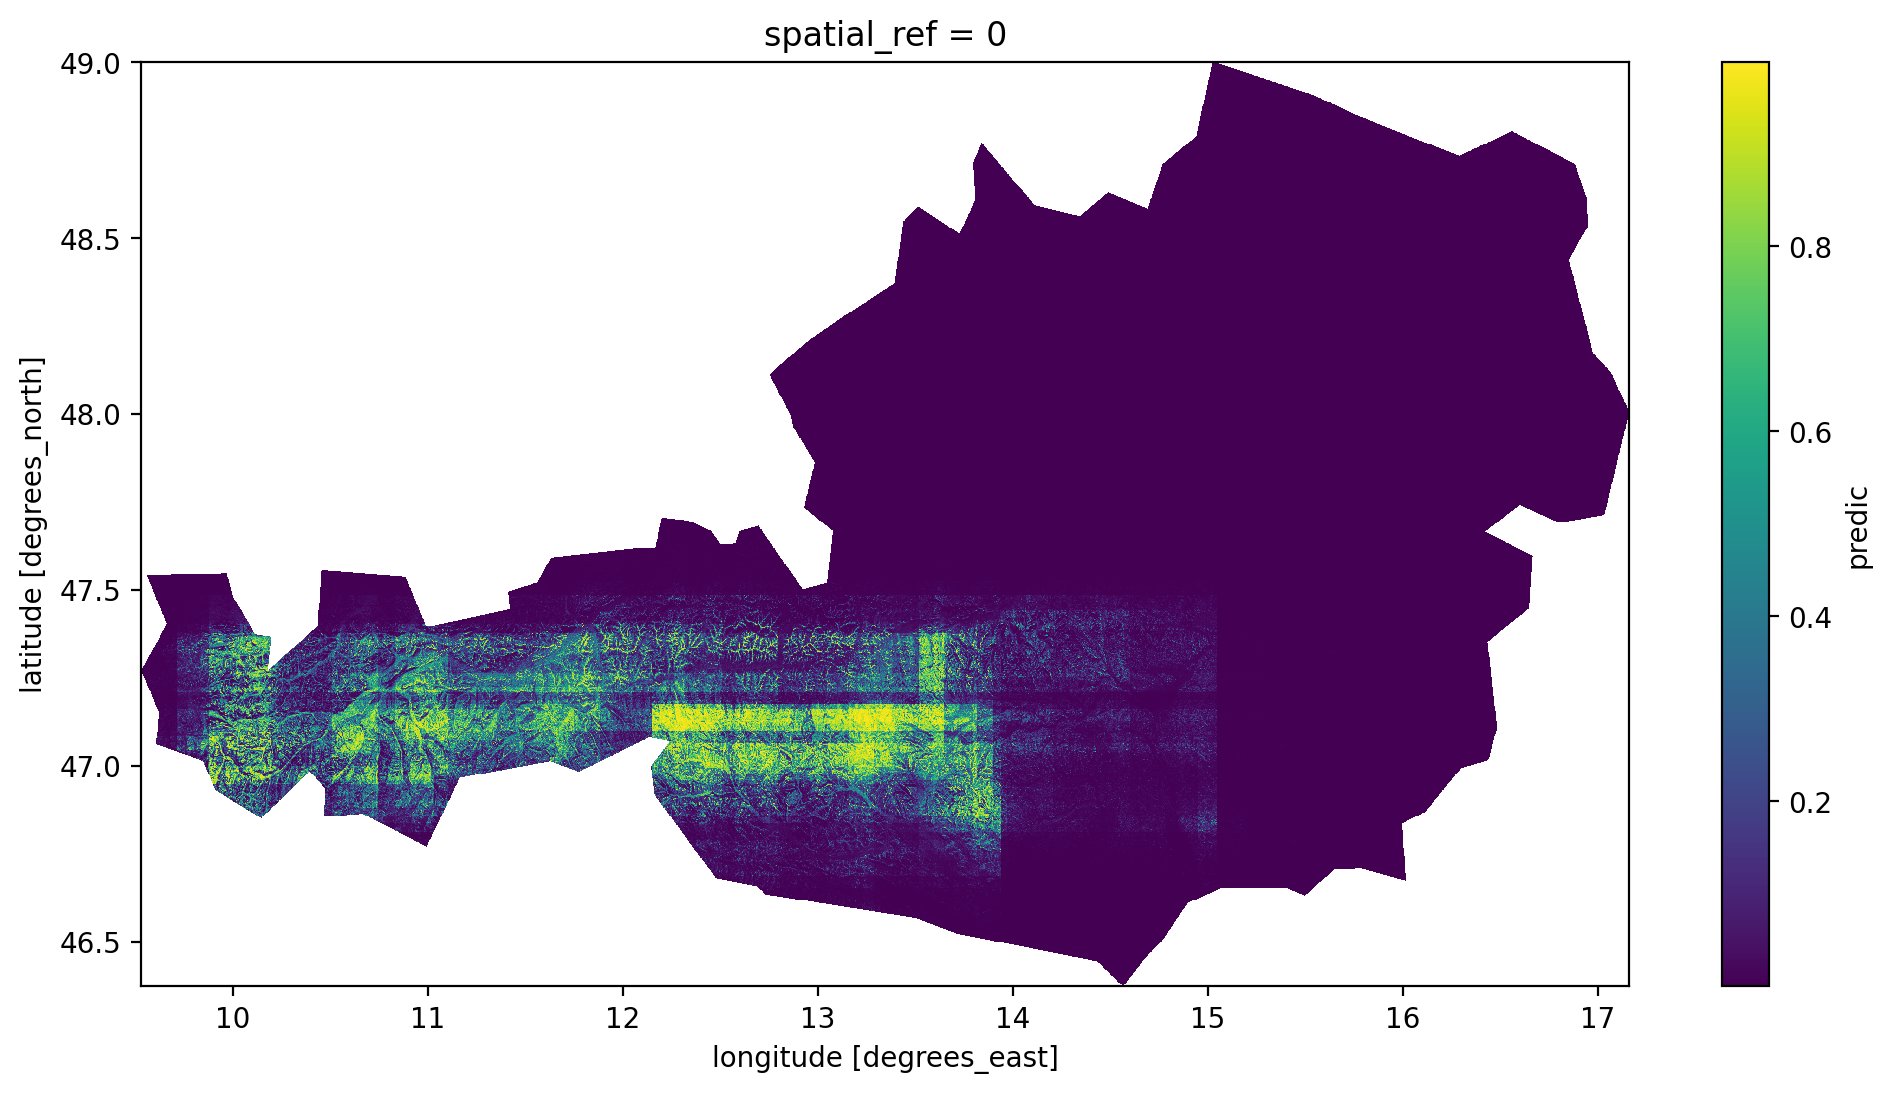

In [82]:
# Due to the high importance of lat and lon the result for those features is not good at all
%config InlineBackend.figure_format='retina'
plt.figure(figsize=[12,6])
xr_fit.predic.T.plot()